<a href="https://colab.research.google.com/github/itz-abhay/Earning-Manipulation-Detection/blob/main/Earning_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Earning Manipulation Detection

###Load in needed packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string as st

#Benford Law

> Benford's Law, also known as the First-Digit Law, is a statistical principle stating that in many naturally occurring datasets, the leading digits of numerical values are not uniformly distributed. Specifically, smaller digits like 1, 2, and 3 occur more frequently as first digits than larger ones like 8 or 9. This phenomenon is counterintuitive, as one might expect all digits to appear with equal likelihood. Benford's Law has applications in fraud detection, data validation, and forensic accounting, where deviations from this expected distribution may indicate anomalies or inaccuracies in datasets.


> In simpler terms, Benford's Law highlights a surprising pattern in real-world numerical data, revealing that certain digits tend to appear more frequently at the beginning of numbers. This unexpected pattern has practical uses in uncovering irregularities in financial statements or datasets by comparing the actual distribution of first digits to the expected distribution according to Benford's Law.





In [ ]:
import pandas as pd

df = pd.read_csv('m_score_dataset_final.csv')

#Creating new column that keeps the duplicate column names dup_sale so to keep the original data untouched
df['dup_sale'] = df['sale']


####Few preprocessing that'll help in frequency counting of first digit

In [ ]:
# Check if the 'dup_sale' value is negative, then multiply by -1 and make it positive
df['dup_sale'] = df['dup_sale'].apply(lambda x: x * -1 if x < 0 else x)

# Check if the 'dup_sale' value is less than 1, then multiply by 10 until it becomes
# greater than or equal to 1 For eg: 0.02324 -> 2.324
df['dup_sale'] = df['dup_sale'].apply(lambda x: x * 10 if x < 1 else x)

In [ ]:
# Convert 'dup_sale' column to string and extract the first character
df['first_digit'] = df['dup_sale'].astype(str).apply(lambda x: int(str(x)[0]))

# Filter out rows where the first digit is 0
df = df[df['first_digit'] != 0]

In [ ]:
# Count the frequencies of the first values
frequency_counts = df['first_digit'].value_counts().sort_index()

# Print the frequency counts
print(frequency_counts)

1    51876
2    30696
3    21143
4    16811
5    13525
6    11545
7     9778
8     8655
9     7606
Name: first_digit, dtype: int64


Here, we can see clearly there is no value starting with negative or zero. All first digits are between 1-9

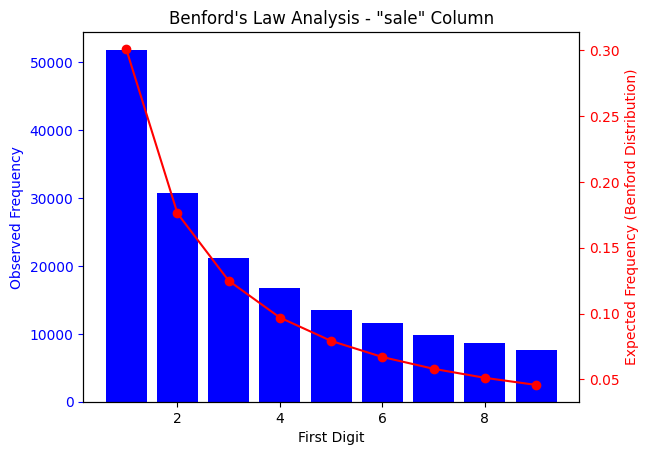

In [ ]:
import matplotlib.pyplot as plt


# Calculate the observed frequency for each digit
observed_frequencies = (frequency_counts / len(df['sale']))

# Step 6: Calculate the expected frequency using Benford's Law formula
expected_frequencies = np.log10(1 + 1 / np.arange(1, 10))

# Shift the x-axis values by one step to the right
# If we won't shift then plotting will happen from o itself but we want it between 1-9
x_values = np.arange(1, 10)

#Compare observed and expected frequencies
# Plot the observed frequencies using a bar plot
fig, ax1 = plt.subplots()

ax1.bar(observed_frequencies.index, frequency_counts, color='blue', label='Observed')
ax1.set_xlabel('First Digit')
ax1.set_ylabel('Observed Frequency', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(x_values, expected_frequencies, marker='o', linestyle='-', color='red', label='Expected (Benford)')
ax2.set_ylabel('Expected Frequency (Benford Distribution)', color='red')
ax2.tick_params('y', colors='red')

plt.title('Benford\'s Law Analysis - "sale" Column')
plt.show()


#Accruals Model
Crashing

In [ ]:
pip install linearmodels

In [ ]:
pip install statsmodels

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load the CSV file into a DataFrame
df = pd.read_csv('m_score_dataset_final.csv')

# Data Manipulation with pandas
df['at_lag1'] = df.groupby('gvkey')['at'].shift(1)
df['rev_lag1'] = df.groupby('gvkey')['sale'].shift(1)
df['rec_lag1'] = df.groupby('gvkey')['rect'].shift(1)
df['oancf_lag1'] = df.groupby('gvkey')['oancf'].shift(1)

df = df[df['at_lag1'] != 0]

df['accrual'] = (df['ni'] - df['oancf']) / df['at_lag1']
df['cash_revenue'] = (df['rev_lag1'] - df['rec_lag1']) / df['at_lag1']
df['ppe'] = df['ppegt'] / df['at_lag1']

# Selecting specific columns for the fixed effects model
df_subset = df[['accrual', 'cash_revenue', 'ppe', 'gvkey']]

# Drop rows with missing values in the selected columns
df_subset = df_subset.dropna(subset=['accrual', 'cash_revenue', 'ppe'])

# Create dummy variables for entity fixed effects
entity_dummies = pd.get_dummies(df_subset['gvkey'], drop_first=True)

# Merge dummy variables with the subset DataFrame
df_subset = pd.concat([df_subset, entity_dummies], axis=1)

# Fixed Effects Model with statsmodels
X = df_subset[['cash_revenue', 'ppe'] + entity_dummies.columns.tolist()]
X = sm.add_constant(X)  # Add constant term
y = df_subset['accrual']

model = sm.OLS(y, X).fit()

# Summary of the Fixed Effects Model
print(model.summary())

# Residual Calculation
df_subset['residual'] = model.resid.abs()


<ipython-input-1-b188604f9baa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accrual'] = (df['ni'] - df['oancf']) / df['at_lag1']
<ipython-input-1-b188604f9baa>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cash_revenue'] = (df['rev_lag1'] - df['rec_lag1']) / df['at_lag1']
<ipython-input-1-b188604f9baa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

#M-Score

The M-Score, or Manipulation Score, is a financial metric designed to assess the likelihood of financial statement manipulation or earnings management by a company. It was developed by Messod Beneish, an accounting professor. The M-Score is calculated based on a combination of financial ratios and accounting-based indicators, with higher scores indicating a higher likelihood of manipulation.

The M-Score considers various factors such as changes in revenue, expenses, and other financial statement items to create a composite score. Companies with higher M-Scores are flagged as having a higher probability of financial manipulation, potentially signaling concerns about the quality of reported financial information. It is often used as a tool by investors and analysts to evaluate the credibility and reliability of a company's financial statements.

####create more variables for M-Score Calculation

In [ ]:
df = pd.read_csv('/content/m_score_dataset_final.csv')



> 'pre_sale' calculates the previous year's sales ('sale') for each company ('gvkey') by shifting the sales values within each group based on the fiscal year ('fyear').



> It enables the examination of changes in sales over time, aiding in the assessment of potential financial manipulation or irregularities in reported earnings.




In [ ]:
df['pre_sale'] = df.sort_values(['fyear']).groupby('gvkey')['sale'].shift()



> The new column 'pre_cogs' computes the previous year's cost of goods sold ('cogs') for each company ('gvkey') by shifting the cost values within each group based on the fiscal year ('fyear'). This is valuable for financial analysis, particularly in M-Score calculations, as it facilitates the examination of changes in cost of goods sold over time. Understanding historical trends in costs aids in evaluating the financial health and potential manipulation of reported earnings.



In [ ]:
df['pre_cogs'] = df.sort_values(['fyear']).groupby('gvkey')['cogs'].shift()



> The 'pre_rect' column is created by shifting the values of the 'rect' (accounts receivable) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column provides the previous year's accounts receivable for each company, aiding in financial analysis. It is particularly useful in detecting patterns or anomalies in the management of accounts receivable over time, contributing to assessments of liquidity, financial stability, and potential accounting irregularities.



In [ ]:
df['pre_rect'] = df.sort_values(['fyear']).groupby('gvkey')['rect'].shift()



> The 'pre_act' column is generated by shifting the values of the 'act' (current assets) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the previous year's total current assets for each company. It proves valuable in financial analysis by facilitating the examination of trends and changes in a company's current asset management over time. Assessing the variations in current assets can offer insights into a company's liquidity, operational efficiency, and overall financial health.



In [ ]:
df['pre_act'] = df.sort_values(['fyear']).groupby('gvkey')['act'].shift()



> The 'pre_ppegt' column is created by shifting the values of the 'ppegt' (net property, plant, and equipment) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the previous year's net property, plant, and equipment for each company. It is useful in financial analysis to track changes in a company's investment in long-term assets. Monitoring variations in net property, plant, and equipment over time can provide insights into a company's capital expenditure, asset management strategy, and overall financial stability.



In [ ]:
df['pre_ppegt'] = df.sort_values(['fyear']).groupby('gvkey')['ppegt'].shift()



> The 'pre_dp' column is generated by shifting the values of the 'dp' (depreciation and amortization) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the previous year's depreciation and amortization for each company. It is valuable in financial analysis for assessing the historical trend in the company's non-cash expenses related to the wear and tear of its long-term assets. Understanding changes in depreciation and amortization over time can aid in evaluating a company's asset management efficiency and estimating future capital expenditures.



In [ ]:
df['pre_dp'] = df.sort_values(['fyear']).groupby('gvkey')['dp'].shift()



> The 'pre_at' column is derived by shifting the values of the 'at' (total assets) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the total assets of the company from the previous fiscal year. It is useful in financial analysis for examining the historical trajectory of a company's overall asset base. Analyzing changes in total assets over time can provide insights into the company's growth, investment strategies, and financial health. This information is crucial for assessing a company's ability to generate returns on its assets and manage its resources effectively.



In [ ]:
df['pre_at'] = df.sort_values(['fyear']).groupby('gvkey')['at'].shift()



> The 'pre_xsga' column is created by shifting the values of the 'xsga' (selling, general, and administrative expenses) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the selling, general, and administrative expenses from the previous fiscal year. It is valuable in financial analysis for assessing trends and changes in a company's operational costs over time. By comparing current and previous fiscal year values, analysts can evaluate the efficiency of cost management, identify potential areas for improvement, and make informed decisions about the company's operational strategies.


In [ ]:
df['pre_xsga'] = df.sort_values(['fyear']).groupby('gvkey')['xsga'].shift()



> The 'pre_ni' column is generated by shifting the values of the 'ni' (net income) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the net income from the previous fiscal year. It is useful in financial analysis for evaluating the historical performance and profitability trends of a company. By comparing current and previous fiscal year net income figures, analysts can assess the company's financial stability, growth, and overall profitability trajectory. This information aids in making informed decisions and projections related to the company's financial health and future prospects.



In [ ]:
df['pre_ni'] = df.sort_values(['fyear']).groupby('gvkey')['ni'].shift()



> The 'pre_oancf' column is created by shifting the values of the 'oancf' (operating cash flow) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the operating cash flow from the previous fiscal year. It is valuable in financial analysis as it provides insights into a company's historical cash generation capabilities. Analysts can use this information to evaluate the consistency and trends in a company's operating cash flow, which is crucial for assessing its liquidity, financial stability, and ability to meet short-term obligations. Monitoring changes in operating cash flow over time helps in identifying potential financial risks and opportunities.



In [ ]:
df['pre_oancf'] = df.sort_values(['fyear']).groupby('gvkey')['oancf'].shift()



> The 'pre_lct' column is created by shifting the values of the 'lct' (current liabilities) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the current liabilities from the previous fiscal year. It is useful in financial analysis to examine how a company's current liabilities have changed over time. Current liabilities are obligations that a company is expected to settle within one year, and tracking the historical trend helps assess a company's short-term debt management and liquidity. Analyzing changes in current liabilities can provide insights into a company's working capital management and its ability to meet its short-term obligations efficiently.


In [ ]:
df['pre_lct'] = df.sort_values(['fyear']).groupby('gvkey')['lct'].shift()



> The 'pre_dltt' column is created by shifting the values of the 'dltt' (long-term debt) column within each company ('gvkey') based on the fiscal year ('fyear'). This new column represents the long-term debt from the previous fiscal year. It is useful in financial analysis to examine how a company's long-term debt has changed over time. Long-term debt is debt that matures in more than one year, and tracking its historical trend helps assess a company's capital structure and financial leverage. Analyzing changes in long-term debt can provide insights into a company's borrowing and financing strategies, as well as its ability to manage long-term financial obligations.



In [ ]:
df['pre_dltt'] = df.sort_values(['fyear']).groupby('gvkey')['dltt'].shift()

In [ ]:
#printing the first 5 rows of your DataFrame
df.head(5)

,gvkey,conm,datadate,fyear,sale,cogs,rect,act,ppegt,dp,...,pre_rect,pre_act,pre_ppegt,pre_dp,pre_at,pre_xsga,pre_ni,pre_oancf,pre_lct,pre_dltt
0,1003,A.A. IMPORTING CO INC,10623,1988.0,32.807999,21.719999,2.148000,14.65600,2.593000,0.692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003,A.A. IMPORTING CO INC,10988,1989.0,19.267000,11.883000,1.373000,9.19000,2.281000,0.790,...,2.148000,14.65600,2.593000,0.692,16.280001,14.768000,-7.838000,-2.100,16.370001,0.104000
2,1004,AAR CORP,10743,1988.0,406.359990,303.056000,95.218002,257.04800,85.414001,6.436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,AAR CORP,11108,1989.0,444.875000,336.931000,93.581001,275.57599,105.646000,7.181,...,95.218002,257.04800,85.414001,6.436,356.390990,52.252998,24.813999,0.094,128.104000,25.707001
4,1004,AAR CORP,11473,1990.0,466.541990,366.040010,91.237999,268.39899,113.060000,8.256,...,93.581001,275.57599,105.646000,7.181,388.521000,53.911999,25.655001,19.371,90.643997,72.329002


Plotting the graph that contains the mean growth of net income 'ni' and Total asset 'at', year wise

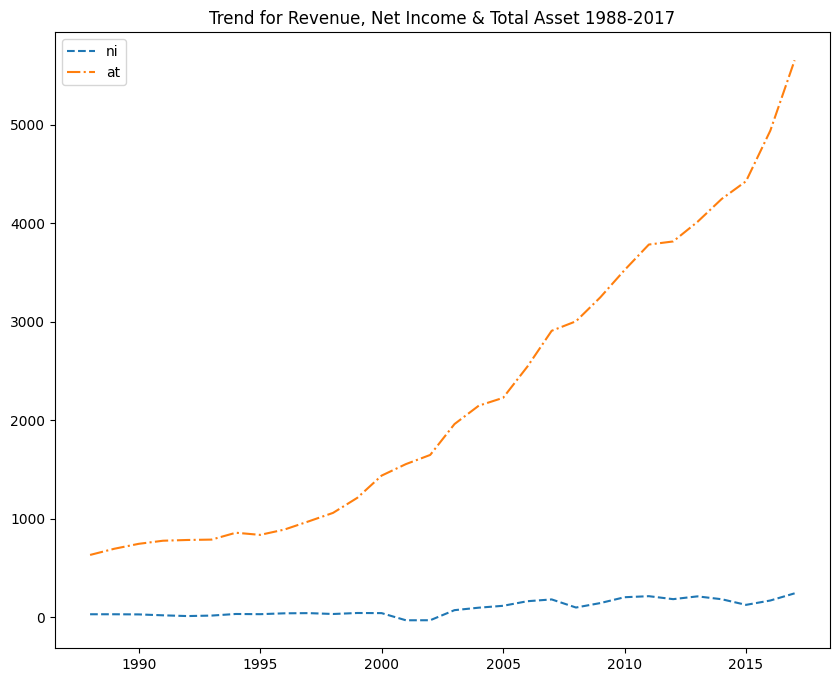

In [ ]:
#Creating a new dataframe
#keeping fyear as index and other two extra columns that is having mean of 'ni'
# and mean of 'at'
df2 = df.groupby('fyear').agg({ 'ni':'mean', 'at':'mean'})

plt.figure(figsize=(10,8))
# plt.plot(df2['revt'], linestyle = 'solid')
plt.plot(df2['ni'], linestyle = 'dashed')
plt.plot(df2['at'], linestyle = 'dashdot')
plt.legend(df2.columns.values.tolist())
plt.title('Trend for Revenue, Net Income & Total Asset 1988-2017')
plt.show()

In [ ]:
# Calculate the proportion of assets not tied up in current assets or gross property, plant, and equipment
# Helpful for M-score calculation as it reflects the quality of assets available to cover liabilities
# df['asset_qual'] = (df['at'] - df['act'] - df['ppegt']) / df['at']

df['asset_qual'] = (df['at'] - df['act'] - df['ppegt']) / df['at']

In [ ]:
# Calculate the proportion of assets not tied up in current assets or gross property, plant, and equipment for the previous year
# Helpful for M-score calculation as it reflects the quality of assets available to cover liabilities in the previous year
# df['pre_asset_qual'] = (df['pre_at'] - df['pre_act'] - df['pre_ppegt']) / df['pre_at']

df['pre_asset_qual'] = (df['pre_at'] - df['pre_act'] - df['pre_ppegt']) / df['pre_at']

In [ ]:
# Eight ratios
# Calculate the Days Sales of Receivables Index (DSRI) to assess changes in the speed of receiving payments
# Helpful for M-score calculation as it reflects the effectiveness of managing accounts receivable
# df['DSRI'] = (df['rect'] / df['sale']) / (df['pre_rect'] / df['pre_sale'])

df['DSRI'] = (df['rect']/df['sale']) / (df['pre_rect'] / df['pre_sale'])

In [ ]:
# Calculate the Gross Margin Index (GMI) to evaluate changes in gross profit margin
# Useful for M-score calculation as it indicates alterations in gross profitability
# df['GMI'] = ((df['pre_sale'] - df['pre_cogs']) / df['pre_sale']) / ((df['sale'] - df['cogs']) / df['sale'])
df['GMI'] =  ((df['pre_sale']-df['pre_cogs'])/df['pre_sale']) / ((df['sale']-df['cogs'])/df['sale'])

In [ ]:
# Calculate the Asset Quality Index (AQI) to assess changes in asset quality
# Useful for M-score calculation as it reflects variations in the quality of assets
# df['AQI'] = df['asset_qual'] / df['pre_asset_qual']

df['AQI'] = df['asset_qual'] / df['pre_asset_qual']

In [ ]:
# Calculate the Sales Growth Index (SGI) to evaluate changes in sales over time
# Useful for M-score calculation as it captures variations in sales growth
# df['SGI'] = df['sale'] / df['pre_sale']
df['SGI'] = df['sale'] / df['pre_sale']

In [ ]:
# Calculate the Depreciation Index (DEPI) to assess changes in the proportion of depreciation to fixed assets
# Useful for M-score calculation to gauge the quality of assets
# df['DEPI'] = (df['pre_dp'] / (df['pre_dp'] + df['pre_ppegt'])) / (df['dp'] / (df['dp'] + df['ppegt']))
df['DEPI'] = (df['pre_dp'] / (df['pre_dp'] + df['pre_ppegt'])) / (df['dp'] / (df['dp'] + df['ppegt']))

In [ ]:
# Calculate the Selling, General, and Administrative Expenses Index (SGAI) to assess changes in the proportion of SG&A expenses to sales
# Useful for M-score calculation to gauge the efficiency of selling and administrative expenses
# df['SGAI'] = (df['xsga'] / df['sale']) / (df['pre_xsga'] / df['pre_sale'])
df['SGAI'] = (df['xsga'] / df['sale']) / (df['pre_xsga'] / df['sale'])

In [ ]:
# Calculate the Total Accruals (TA) as a proportion of total assets
# Useful for M-score calculation to evaluate the quality of reported earnings
# df['TA'] = (df['ni'] - df['oancf']) / df['at']
df['TA'] = (df['ni'] - df['oancf']) / df['at']

In [ ]:
# Calculate the Leverage (LVGI) as a proportion of total assets
# Useful for M-score calculation to evaluate the financial leverage
# df['LVGI'] = ((df['lct'] + df['dltt']) / df['at']) / ((df['pre_lct'] + df['pre_dltt']) / df['pre_at'])
df['LVGI'] = ((df['lct'] + df['dltt']) / df['at']) / ((df['pre_lct'] + df['pre_dltt']) / df['pre_at'])

#Finally, with these ratios in hand, we can calculate the M-Score.

In [ ]:
def m_score_df():
    df = pd.read_csv('m_score_dataset_final.csv')

    # Create prvious year data
    df['pre_sale'] = df.sort_values(['fyear']).groupby('gvkey')['sale'].shift()
    df['pre_cogs'] = df.sort_values(['fyear']).groupby('gvkey')['cogs'].shift()
    df['pre_rect'] = df.sort_values(['fyear']).groupby('gvkey')['rect'].shift()
    df['pre_act'] = df.sort_values(['fyear']).groupby('gvkey')['act'].shift()
    df['pre_ppegt'] = df.sort_values(['fyear']).groupby('gvkey')['ppegt'].shift()
    df['pre_dp'] = df.sort_values(['fyear']).groupby('gvkey')['dp'].shift()
    df['pre_at'] = df.sort_values(['fyear']).groupby('gvkey')['at'].shift()
    df['pre_xsga'] = df.sort_values(['fyear']).groupby('gvkey')['xsga'].shift()
    df['pre_ni'] = df.sort_values(['fyear']).groupby('gvkey')['ni'].shift()
    df['pre_oancf'] = df.sort_values(['fyear']).groupby('gvkey')['oancf'].shift()
    df['pre_lct'] = df.sort_values(['fyear']).groupby('gvkey')['lct'].shift()
    df['pre_dltt'] = df.sort_values(['fyear']).groupby('gvkey')['dltt'].shift()

    # Create derived variable
    df['asset_qual'] = (df['at'] - df['act'] - df['ppegt']) / df['at']
    df['pre_asset_qual'] = (df['pre_at'] - df['pre_act'] - df['pre_ppegt']) / df['pre_at']

    df['DSRI'] = (df['rect']/df['sale']) / (df['pre_rect'] / df['pre_sale'])
    df['GMI'] =  ((df['pre_sale']-df['pre_cogs'])/df['pre_sale']) / ((df['sale']-df['cogs'])/df['sale'])
    df['AQI'] = df['asset_qual'] / df['pre_asset_qual']
    df['SGI'] = df['sale'] / df['pre_sale']
    df['DEPI'] = (df['pre_dp'] / (df['pre_dp'] + df['pre_ppegt'])) / (df['dp'] / (df['dp'] + df['ppegt']))
    df['SGAI'] = (df['xsga'] / df['sale']) / (df['pre_xsga'] / df['sale'])
    df['TA'] = (df['ni'] - df['oancf']) / df['at']
    df['LVGI'] = ((df['lct'] + df['dltt']) / df['at']) / ((df['pre_lct'] + df['pre_dltt']) / df['pre_at'])

    # M-score
    df['M-Score'] = -4.84 + .920 * df['DSRI'] + .528 * df['GMI'] + .404 * df['AQI'] \
                    + .892 * df['SGI'] + .115 * df['DEPI'] - .172 * df['SGAI'] + 4.679 * df['TA'] - .327 * df['LVGI']

    return df

In [ ]:
df['M-Score'] = -4.84 + .920 * df['DSRI'] + .528 * df['GMI'] + .404 * df['AQI'] + .892 * df['SGI'] + .115 * df['DEPI'] - .172 * df['SGAI'] + 4.679 * df['TA'] - .327 * df['LVGI']

#Step 3: Write function to create annual M-Score data frame for a specific company

In [ ]:
def m_score_company(company_name):
    company_name = company_name.upper()
    df = m_score_df()
    if df is None:
        print("Error: m_score_df() returned None.")
        return
    df1 = df[['gvkey','conm','fyear','M-Score']]
    df2 = df1[df1['conm'].str.contains(company_name)]
    df3 = df2.dropna()
    df3 = df3.reset_index()

    return df3

#Example

In [ ]:
m_score_company('twitter')

,index,gvkey,conm,fyear,M-Score
0,74553,18872,TWITTER INC,2012.0,-1.955942
1,74554,18872,TWITTER INC,2013.0,-1.424558
2,74555,18872,TWITTER INC,2014.0,-3.162791
3,74556,18872,TWITTER INC,2015.0,-2.474192
4,74557,18872,TWITTER INC,2016.0,-3.394550
5,74558,18872,TWITTER INC,2017.0,-3.293757


#Step 4: Create a visualization function with red flag lines

With the function above, I have created one more function for ploting, m_score_trend_graph(company_name). M-Score has two thresholds:

If M-Score is larger than -1.78, it indicates a red flag, which indicates serious manipulation.
If M-Score is between -2.22 and -1.78, it indicates yellow flag, which indicates slight manipulation.

In [ ]:
def m_score_trend_graph(company_name):
    df = m_score_company(company_name)
    company_name = df['conm'][0]
    df1 = df[['fyear','M-Score']]
    df1['fyear'] = df1['fyear'].round(1)
    df1 = df1.set_index('fyear')
    company_name1 = st.capwords(company_name)

    fig, ax = plt.subplots(figsize = (13,8))
    ax.plot(df1, 'b^--')
    ax.axhline(y = -1.78, color = 'r', linestyle = '-')
    ax.axhline(y = -2.22, color = 'g', linestyle = '-')
    ax.set_title(company_name1 + ' : M Score across Year', fontsize = 15)
    plt.show()

#Let’s Play！

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


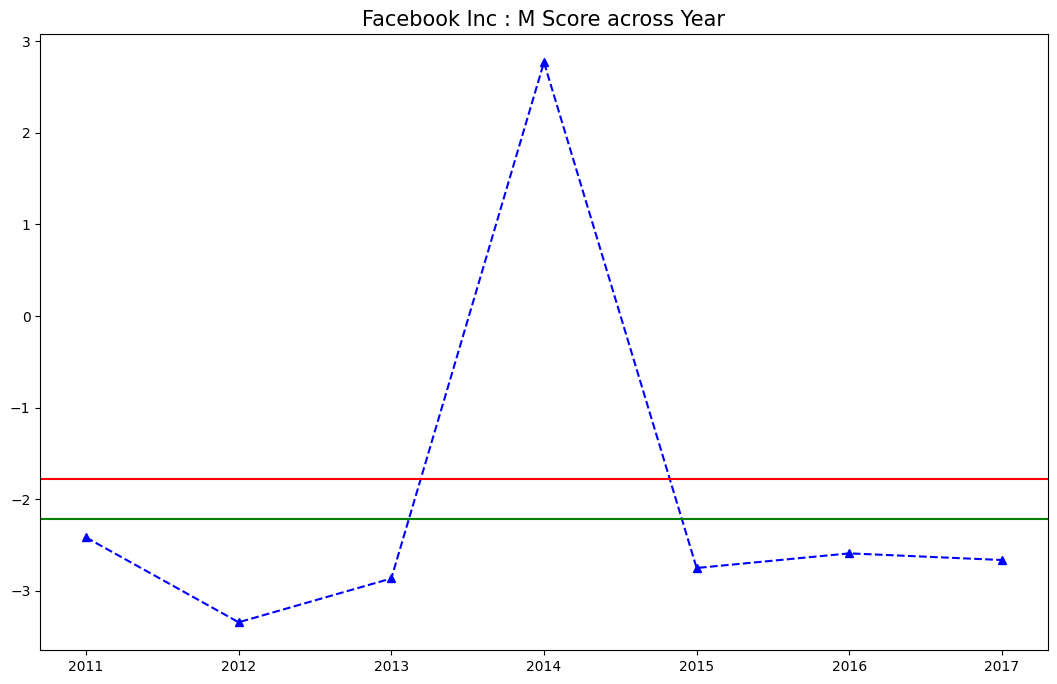

In [ ]:
m_score_trend_graph('facebook')

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


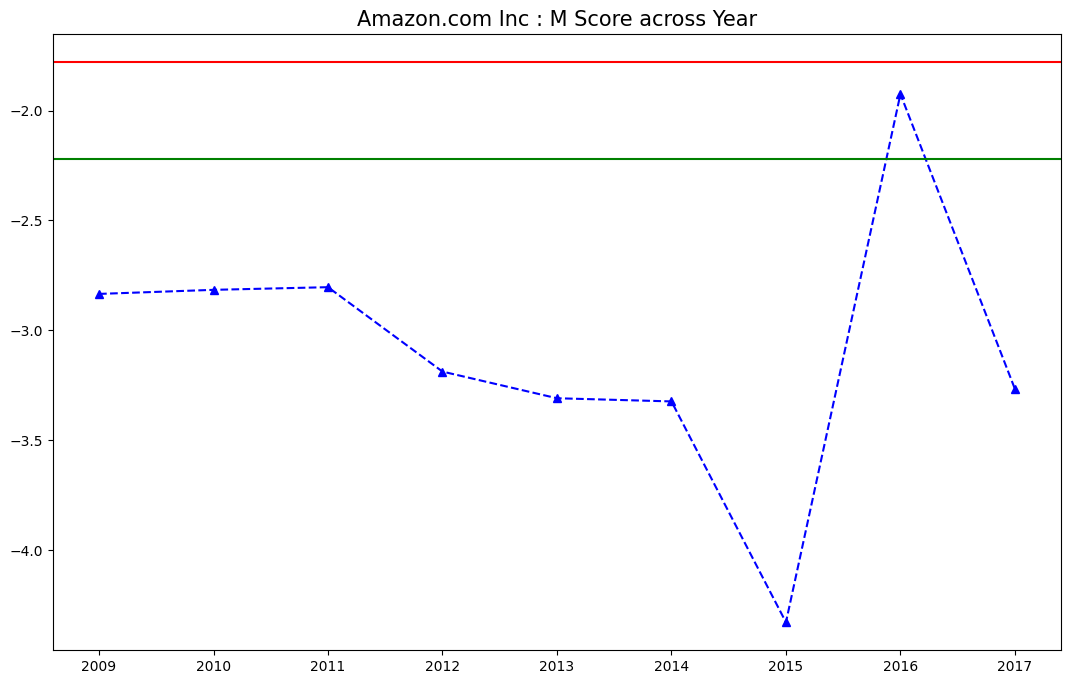

In [ ]:
m_score_trend_graph('amazon')

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


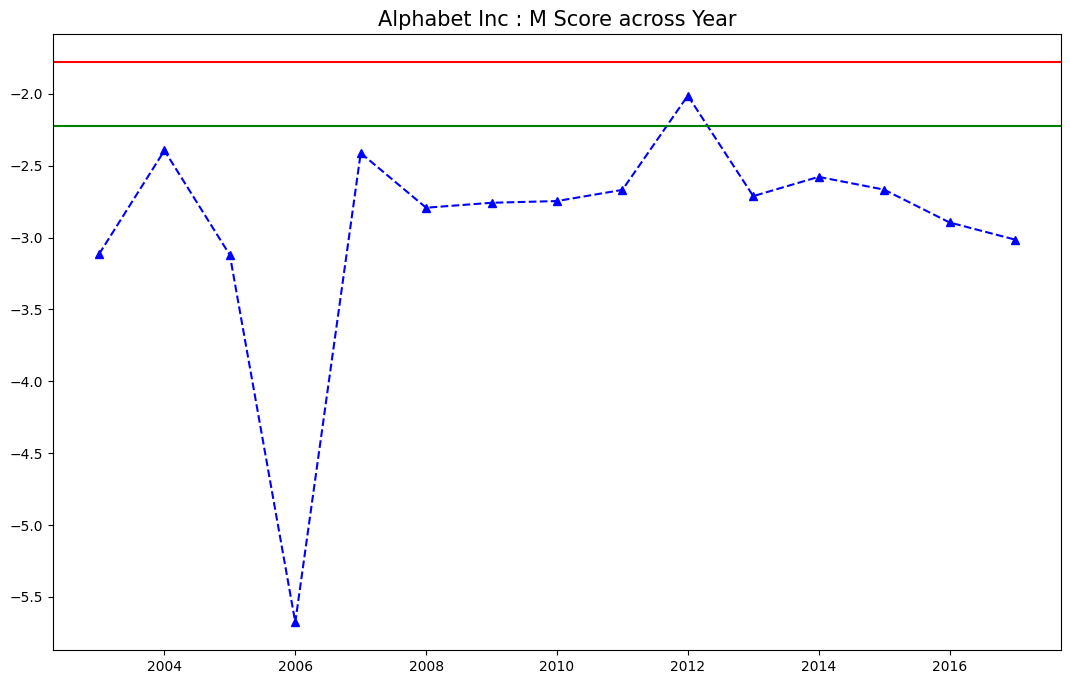

In [ ]:
m_score_trend_graph('alphabet')

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


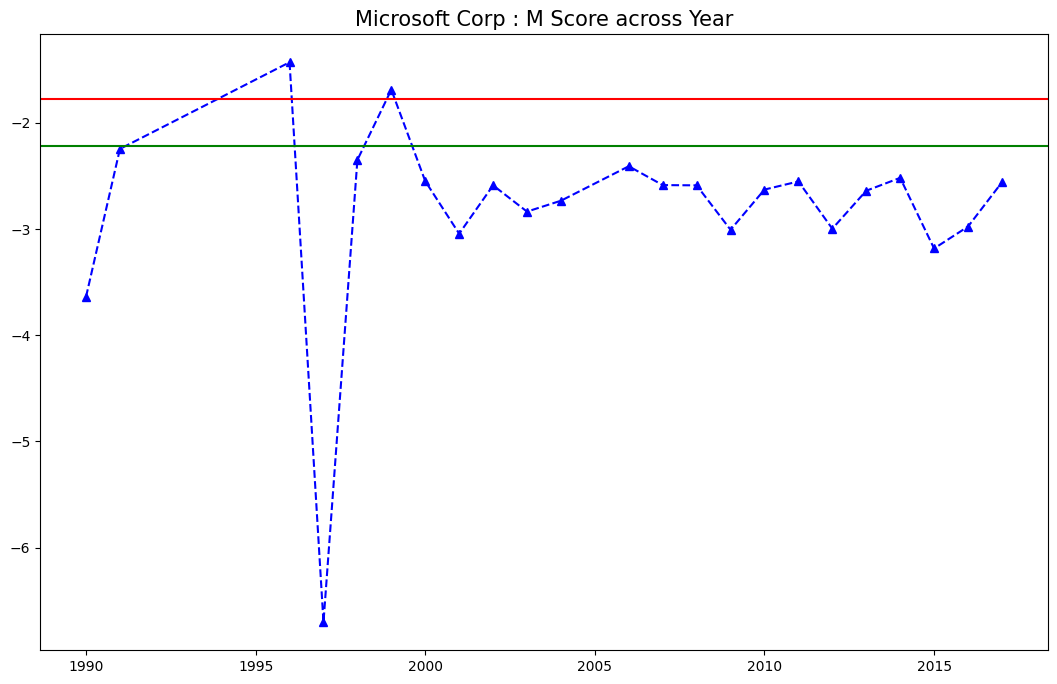

In [ ]:
m_score_trend_graph('microsoft')

##Observations
For these four companies, most of the time they are in the safe range of M-Score, indicating most of the time they didn’t resemble like an earning manipulator. For certain points which are in the red-flag zone are worth further investigation.

Let’s try our M-Generator for some fortune 500 companies in Minneapolis.

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


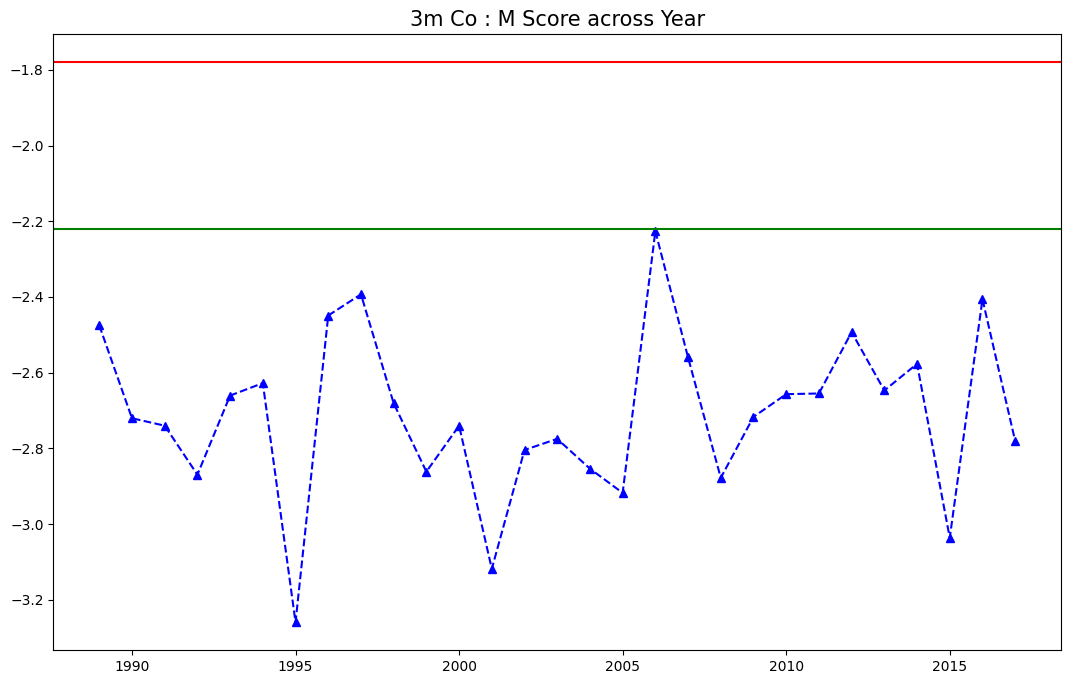

In [ ]:
m_score_trend_graph('3M co')

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


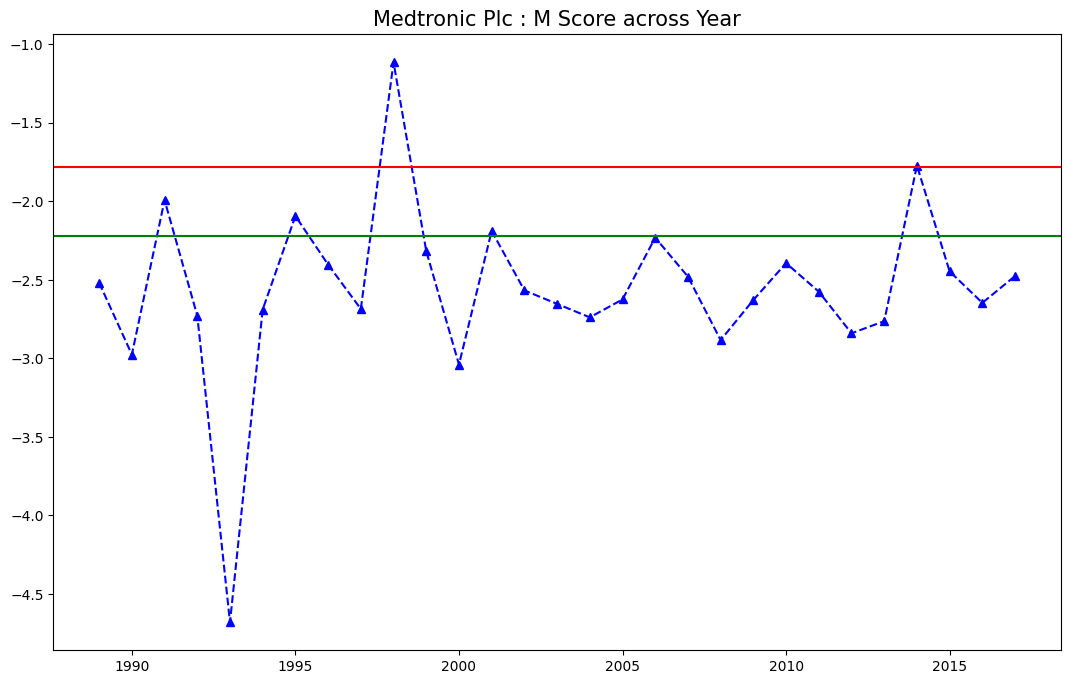

In [ ]:
m_score_trend_graph('medtronic')

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


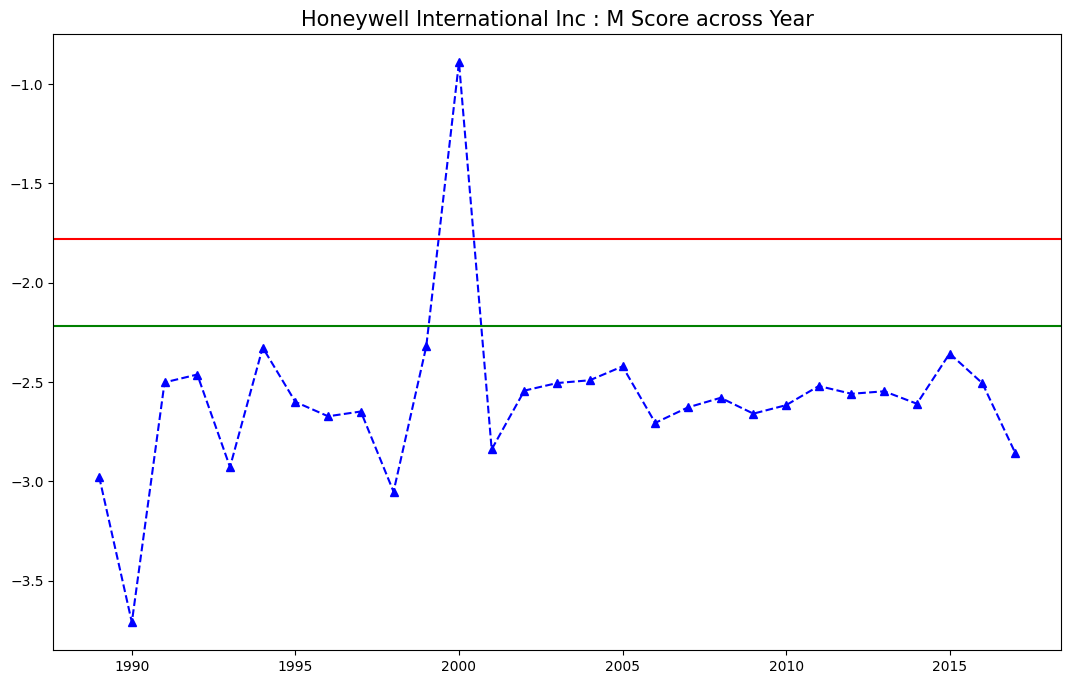

In [ ]:
m_score_trend_graph('honeywell international')

Observations
3M is so far the company which seems least likely to be an earning manipulator based on its M-Score.

##Limitation of M-Score Generator
There are two main limitations of the M-Score Generator and can be further improved.

If some financial metrics are not reported by companies and not reported in the Compustat database. The M-Score graphs can’t be generated. Take Netflix for instance.

In [ ]:
m_score_company('netflix')
# results
# Empty DataFrame
# Columns: [index, gvkey, conm, fyear, M-Score]
# Index: []

,index,gvkey,conm,fyear,M-Score


It is because Netflix has all zero in the receivable column, which cripples our functions. I think probably as a next step, I would be finding new sources for missing columns.

2. Look up function is not very accurate. If a user inserted some general keyword for a company, it will return the column with all matched companies and mess up the graph.

<ipython-input-36-7ba2b766969c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['fyear'] = df1['fyear'].round(1)


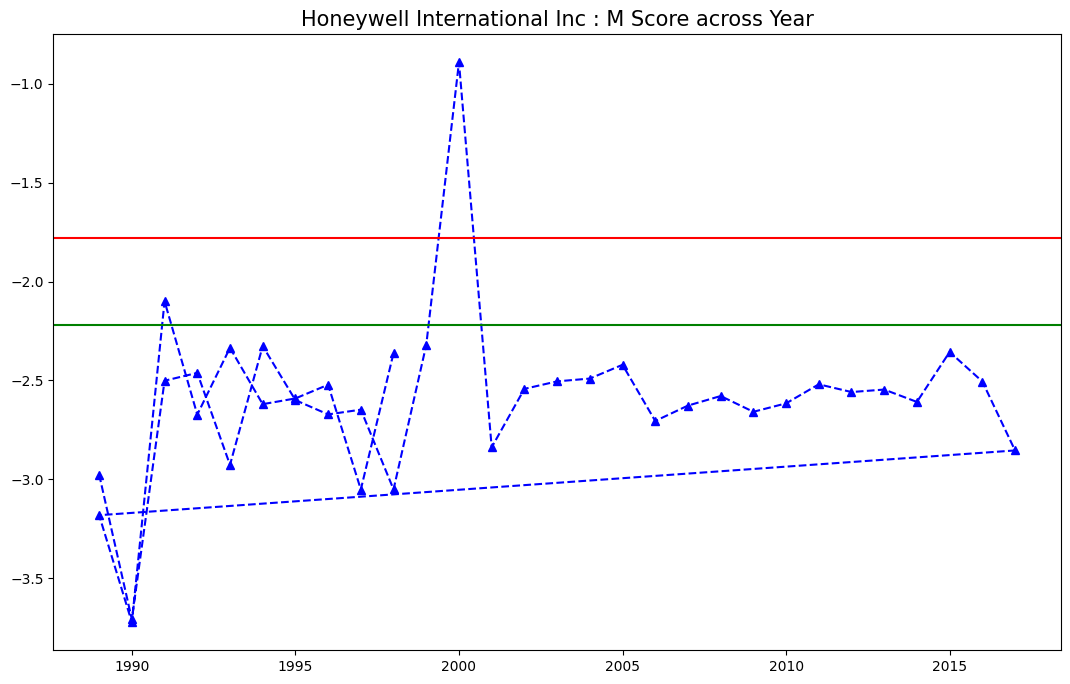

In [ ]:
m_score_trend_graph('honeywell')

If I only type ‘honeywell’ in the function, the lines will be messed up. It is because it will return result of both ‘HONEYWELL INTERNATIONAL INC’ and ‘HONEYWELL INC.’